# Churn Prediction

## Libraries

In [90]:
import pandas as pd
import numpy as np
import seaborn as sb
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import FloatType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from pyspark.ml.tuning import CrossValidator
from sklearn.metrics import confusion_matrix

## Functions

In [91]:
#ROC courve plotting
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

## Data 

In [92]:
churn = pd.read_csv('/Users/user/Desktop/Data Scientis R Python SQL/Datasets/Churn/BankChurners.csv')

#Delete unnecesary columns
churn = churn[churn.columns[:-2]]

## Columns references 

CLIENTNUM : Client number. Unique identifier for the customer holding the account

Attrition_Flag: Internal event (customer activity) variable - if the account is closed then 1 else 0

Customer_Age: Demographic variable - Customer's Age in Years

Gender: Demographic variable - M=Male, F=Female

Dependent_count: Demographic variable - Number of dependents

Education_Level: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)

Marital_Status: Demographic variable - Married, Single, Divorced, Unknown

Income_Category: Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, >

Card_Category: Product Variable - Type of Card (Blue, Silver, Gold, Platinum)

Months_on_book: Period of relationship with bank

Total_Relationship_Count: Total no. of products held by the customer

Months_Inactive_12_mon: No. of months inactive in the last 12 months

Contacts_Count_12_mon: No. of Contacts in the last 12 months

Credit_Limit: Credit Limit on the Credit Card

Total_Revolving_Bal: Total Revolving Balance on the Credit Card

Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months)

Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1)

Total_Trans_Amt: Total Transaction Amount (Last 12 months)

Total_Trans_Ct: Total Transaction Count (Last 12 months)

Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1)

Avg_Utilization_Ratio: Average Card Utilization Ratio

In [93]:
churn.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Exploratory Data Analysis

In [94]:
round(churn.describe(),2)

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00
mean,7.391776e+08,46.33,2.35,35.93,3.81,2.34,2.46,8631.95,1162.81,7469.14,0.76,4404.09,64.86,0.71,0.27
std,3.690378e+07,8.02,1.30,7.99,1.55,1.01,1.11,9088.78,814.99,9090.69,0.22,3397.13,23.47,0.24,0.28
min,7.080821e+08,26.00,0.00,13.00,1.00,0.00,0.00,1438.30,0.00,3.00,0.00,510.00,10.00,0.00,0.00
25%,7.130368e+08,41.00,1.00,31.00,3.00,2.00,2.00,2555.00,359.00,1324.50,0.63,2155.50,45.00,0.58,0.02
50%,7.179264e+08,46.00,2.00,36.00,4.00,2.00,2.00,4549.00,1276.00,3474.00,0.74,3899.00,67.00,0.70,0.18
75%,7.731435e+08,52.00,3.00,40.00,5.00,3.00,3.00,11067.50,1784.00,9859.00,0.86,4741.00,81.00,0.82,0.50
max,8.283431e+08,73.00,5.00,56.00,6.00,6.00,6.00,34516.00,2517.00,34516.00,3.40,18484.00,139.00,3.71,1.00


In [95]:
#There are not any NA values
churn.isna().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

### Distribution of customer age

In [96]:
fig = make_subplots(rows=2, cols=1)


tr1 = go.Box(x=churn['Customer_Age'],name='Customer Age BoxPlot')
tr2 = go.Histogram(x=churn['Customer_Age'],name='Customer Age Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.show()

The age customer distribution looks as a normal distribution and the average age is 46.

### Distribution of Gender and Card Category

In [97]:
gender = churn.Gender.value_counts()

fig = px.pie(gender, values = gender.values,names = gender.index, title="Gender Proportions",width=400, height=400)

fig.show()

In [98]:
cat = []
for i in (churn.Card_Category.unique()):
    
    cat = churn[['Card_Category','Gender']].value_counts()[i]
    
    fig = px.pie(cat,values = cat.values,names = cat.index, title=i + ' Card Holders: Gender proportions',width=400, height=400)

    fig.show()
    

More samples of females in our dataset are compared to males, but the percentage of difference is not that significant, so we can say that genders are uniformly distributed.

### Distribution of Dependants

In [99]:
fig = make_subplots(rows=2, cols=1)


tr1 = go.Box(x=churn['Dependent_count'],name='Dependants BoxPlot')
tr2 = go.Histogram(x=churn['Dependent_count'],name='Dependants Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.show()

The distribution of Dependent counts is fairly normally distributed with a slight right skew, where the dependant average is 2.



In [100]:
education = churn.Education_Level.value_counts()

fig = px.pie(education,values = education.values, names = education.index, title = 'Proportion of Education Level',width=600, height=600, hole=0.3)

fig.show()

In [101]:
column = []
for i in ['Marital_Status','Income_Category','Card_Category']:
    
    
    column = churn[i]
    
    fig = px.pie(column,values = column.value_counts().values,names = column.value_counts().index, title= i + ' Proportions',width=400, height=400)

    fig.show()
    



In [102]:
customer = churn.Attrition_Flag.value_counts()

fig = px.pie(customer,values = customer.values, names = customer.index, title = 'Customers',width=400, height=400, hole=0.3)

fig.show()


Only the 16% of the samples represent churn customers, so it's necesary use SMOTE function in order to upsample the churn samples and get a balanced data.

## Data Preprocessing

The categorical values are converted to dummy variables. This step is important since machine learning models from Pyspark library require numeric independent variables. 

In [103]:
churn.Attrition_Flag = churn.Attrition_Flag.replace({"Attrited Customer":  1,'Existing Customer':0})

churn.Gender = churn.Gender.replace({"F":  1,'M':0})

churn = pd.concat([churn,pd.get_dummies(churn.Education_Level)],axis = 1).drop('Unknown',axis = 1)

churn = pd.concat([churn,pd.get_dummies(churn.Marital_Status)],axis = 1)

churn = pd.concat([churn,pd.get_dummies(churn.Income_Category)],axis = 1)

churn = pd.concat([churn,pd.get_dummies(churn.Card_Category)],axis = 1)

churn = churn.drop(['Education_Level','Marital_Status','Income_Category','Card_Category','Unknown','CLIENTNUM'], axis = 1)

gender = churn.pop('Gender')

churn = churn.assign(Gender = gender)


In [104]:
#Upsampling churn samples

oversample = SMOTE()

X,y = oversample.fit_resample(X = churn[churn.columns[1:]],y=churn[churn.columns[0]])

upsampled_churn = X.assign(Churn = y)

upsampled_churn


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Blue,Gold,Platinum,Silver,Gender,Churn
0,45,3,39,5,1,3,12691.000000,777,11914.000000,1.335000,...,0,1,0,0,1,0,0,0,0,0
1,49,5,44,6,1,2,8256.000000,864,7392.000000,1.541000,...,0,0,0,1,1,0,0,0,1,0
2,51,3,36,4,1,0,3418.000000,0,3418.000000,2.594000,...,0,0,1,0,1,0,0,0,0,0
3,40,4,34,3,4,1,3313.000000,2517,796.000000,1.405000,...,0,0,0,1,1,0,0,0,1,0
4,40,3,21,5,1,0,4716.000000,0,4716.000000,2.175000,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,40,2,29,2,2,3,3616.000000,1150,2465.789211,0.686422,...,0,0,0,0,1,0,0,0,0,1
16996,56,2,40,3,2,2,2796.057444,0,2796.057444,0.728130,...,0,0,0,1,1,0,0,0,1,1
16997,53,2,44,1,4,2,2312.625528,0,2312.625528,0.388949,...,1,0,0,0,1,0,0,0,0,1
16998,42,2,31,2,3,2,3941.462230,0,3941.462230,0.895899,...,0,0,0,0,1,0,0,0,0,1


There are 34 columns which can be reduced using PCA to reduce the number of dimentions. Principal Component analysis is performed over dummy variables, and will select the number of components which explain most variance.

In [105]:
dummy_columns = upsampled_churn[upsampled_churn.columns[14:-1]].copy()

upsampled_churn = upsampled_churn.drop(dummy_columns.columns,axis = 1)

In [106]:
n_components = 5
pca_model = PCA(n_components)

pca_transform = pca_model.fit_transform(dummy_columns)


fig = px.line(x=[1,2,3,4,5], 
              y=np.cumsum(pca_model.explained_variance_ratio_),
              color = px.Constant("Cumulative Explained Variance"),
             labels=dict(x="PCA components", y="Explained Variance"))

fig.add_bar(x=[1,2,3,4,5],
            y=pca_model.explained_variance_ratio_,
           name = "Individual Explained Variance")

fig.show()

After performed PCA, the 65.5% of the variance is explained taking the 5 components and helps to reduce the data set from 34 variables into 20 ones.

In [107]:
#upsampled_churn = pd.concat([upsampled_churn,pd.DataFrame(pca_transform,columns=['PC1','PC2','PC3','PC4','PC5'])], axis = 1)
upsampled_churn


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Blue,Gold,Platinum,Silver,Gender,Churn
0,45,3,39,5,1,3,12691.000000,777,11914.000000,1.335000,...,0,1,0,0,1,0,0,0,0,0
1,49,5,44,6,1,2,8256.000000,864,7392.000000,1.541000,...,0,0,0,1,1,0,0,0,1,0
2,51,3,36,4,1,0,3418.000000,0,3418.000000,2.594000,...,0,0,1,0,1,0,0,0,0,0
3,40,4,34,3,4,1,3313.000000,2517,796.000000,1.405000,...,0,0,0,1,1,0,0,0,1,0
4,40,3,21,5,1,0,4716.000000,0,4716.000000,2.175000,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,40,2,29,2,2,3,3616.000000,1150,2465.789211,0.686422,...,0,0,0,0,1,0,0,0,0,1
16996,56,2,40,3,2,2,2796.057444,0,2796.057444,0.728130,...,0,0,0,1,1,0,0,0,1,1
16997,53,2,44,1,4,2,2312.625528,0,2312.625528,0.388949,...,1,0,0,0,1,0,0,0,0,1
16998,42,2,31,2,3,2,3941.462230,0,3941.462230,0.895899,...,0,0,0,0,1,0,0,0,0,1


The upsampled dataset is scaled using StandarScaler()

In [108]:
X = upsampled_churn.loc[:,upsampled_churn.columns != 'Churn']
y = upsampled_churn.loc[:,upsampled_churn.columns == 'Churn']

scaler = StandardScaler()

upsampled_churn_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns).assign(Churn = y)


## Model Selection And Evaluation

In [109]:
sc = SparkContext('local[*]','churn prediction')
sc

<SparkContext master=local[*] appName=churn prediction>

In [110]:
spark = SparkSession.builder.appName('Churn_Prediction').getOrCreate()
spark

In [111]:
churn_py = spark.createDataFrame(upsampled_churn_scaled)

In [112]:
churn_py = churn_py.repartition(numPartitions=8)

In [113]:
churn_py.rdd.getNumPartitions()

8

In [114]:
vectorAssembler = VectorAssembler(inputCols = churn_py.columns[:-1],
                           outputCol = 'indep_var')

output = vectorAssembler.transform(churn_py)

churn_py_vec = output.select(['Churn','indep_var'])


In [115]:
#DATA PARTITION

train,test = churn_py_vec.randomSplit([0.75,0.25])


Data partition taking 75% of umpsamped data for training and 25 for testing

### Logistic Regression Model

In [116]:
logit_model = LogisticRegression(featuresCol = 'indep_var', labelCol='Churn',maxIter = 50).fit(train)

In [117]:
pd.DataFrame({'Regressor':['Intercept'] + churn_py.columns[:-1],
             'Coefficient': np.insert(logit_model.coefficients.toArray(),0,logit_model.intercept)})

,Regressor,Coefficient
0,Intercept,0.829769
1,Customer_Age,-0.113672
2,Dependent_count,0.059395
3,Months_on_book,0.030591
4,Total_Relationship_Count,-0.788773
5,Months_Inactive_12_mon,0.348590
6,Contacts_Count_12_mon,0.443847
7,Credit_Limit,-0.099182
8,Total_Revolving_Bal,-0.836605
9,Avg_Open_To_Buy,-0.023572


The positive coefficients impact potitively in the odds, it means, along the value that the variable takes grows the probability of customer churn grows up. The negatives ones, the opposite.

In [118]:
logit_pred = logit_model.transform(test)

logit_eval_data = logit_pred.select(['Churn',"prediction"])

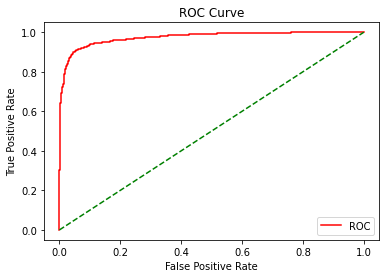

The AUC metric for the Logistic Regression Model is 92.2%


In [119]:
select_prob = udf(lambda v:float(v[1]),FloatType())

prob = logit_pred.select(select_prob('probability')).toPandas()
prob.columns = ['probability']

fper, tper, thresholds = roc_curve(logit_pred.select(["Churn"]).toPandas(), prob)
plot_roc_curve(fper, tper)

print('The AUC metric for the Logistic Regression Model is '+ str(round(roc_auc_score(logit_pred.select(["Churn"]).toPandas(),
                                                                                      logit_pred.select('prediction').toPandas()),3)*100) + '%')



## Random Forest Model

The parameters are independently optimized by taking a range of values and selecting the one with the best accuracy and AUC score.

In [120]:
rf_scores= pd.DataFrame(index = range(0, 4), columns=['n_trees','Accuracy','AUC'])

k = [50,100,500,1000]
j = 0


for i in k:
    
    rf = RandomForestClassifier(labelCol = 'Churn',featuresCol = 'indep_var',featureSubsetStrategy = 'sqrt',numTrees = i,maxDepth = 3,impurity = 'gini', seed = 123).fit(train)
       
    rf_scores.loc[j,'Accuracy'] = rf.evaluate(train).accuracy
    
    rf_scores.loc[j,'n_trees'] = i
    
    rf_scores.loc[j,'AUC'] = rf.evaluate(train).areaUnderROC
    
    j = j+1

fig = px.line(rf_scores, x='n_trees', y=rf_scores.columns[1:],width=800, height=400)    
    
fig.update_layout(
    title = 'Number of tree Selection',
    xaxis_title = 'numTrees',
    yaxis_title = 'Metric Value',
    legend_title = 'Metric Name')

fig.show()

print('The AUC and Accuracy reched the peak when number of tree is 100. The Parameter selected for numTrees is 100')



22/09/19 20:39:24 WARN DAGScheduler: Broadcasting large task binary with size 1463.1 KiB
22/09/19 20:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1467.0 KiB


22/09/19 20:39:29 WARN DAGScheduler: Broadcasting large task binary with size 1070.7 KiB


22/09/19 20:39:32 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/09/19 20:39:34 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


The AUC and Accuracy reched the peak when number of tree is 100. The Parameter selected for numTrees is 100


In [121]:
rf_scores = pd.DataFrame(index = range(0, 3), columns=['Depth','Accuracy','AUC'])

k = [3,5,7]
j = 0


for i in k:
    
    rf = RandomForestClassifier(labelCol = 'Churn',featuresCol = 'indep_var',featureSubsetStrategy = 'sqrt',numTrees = 500,maxDepth = i,impurity = 'gini', seed = 123).fit(train)
       
    rf_scores.loc[j,'Accuracy'] = rf.evaluate(train).accuracy
    
    rf_scores.loc[j,'Depth'] = i
    
    rf_scores.loc[j,'AUC'] = rf.evaluate(train).areaUnderROC
    
    j = j+1

fig = px.line(rf_scores, x='Depth', y=rf_scores.columns[1:],width=800, height=400)

fig.update_layout(
    title = 'Depth Selection',
    xaxis_title = 'Depth',
    yaxis_title = 'Metric Value',
    legend_title = 'Metric Name')

fig.show()

print('The AUC and Accuracy are higher as the Depth increses. The Parameter selected for Depth is 7')

22/09/19 20:39:39 WARN DAGScheduler: Broadcasting large task binary with size 1463.1 KiB
22/09/19 20:39:40 WARN DAGScheduler: Broadcasting large task binary with size 1467.0 KiB


22/09/19 20:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1152.8 KiB


22/09/19 20:39:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/09/19 20:39:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/09/19 20:39:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/09/19 20:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1152.8 KiB


22/09/19 20:39:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/09/19 20:39:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/09/19 20:40:01 WARN DAGScheduler: Broadcasting large task binary with size 1205.0 KiB


22/09/19 20:40:02 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/09/19 20:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1933.1 KiB


22/09/19 20:40:07 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/09/19 20:40:09 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


The AUC and Accuracy are higher as the Depth increses. The Parameter selected for Depth is 7


In [122]:
rf_model = RandomForestClassifier(labelCol = 'Churn',featuresCol = 'indep_var',featureSubsetStrategy = 'sqrt',numTrees = 500,maxDepth = 7,impurity = 'gini', seed = 123).fit(train)

rf_pred = rf_model.transform(test)

22/09/19 20:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1152.8 KiB


22/09/19 20:40:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/09/19 20:40:20 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/09/19 20:40:23 WARN DAGScheduler: Broadcasting large task binary with size 1205.0 KiB


22/09/19 20:40:24 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/09/19 20:40:27 WARN DAGScheduler: Broadcasting large task binary with size 1933.1 KiB


22/09/19 20:40:29 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


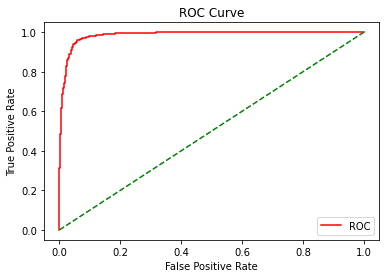

22/09/19 20:40:32 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


The AUC metric for the Random Forest Model is 95.0%


In [123]:
rf_eval_data = rf_pred.select(['Churn',"prediction"])

select_prob = udf(lambda v:float(v[1]),FloatType())

prob = rf_pred.select(select_prob('probability')).toPandas()
prob.columns = ['probability']

fper, tper, thresholds = roc_curve(rf_pred.select(["Churn"]).toPandas(), prob)
plot_roc_curve(fper, tper)

print('The AUC metric for the Random Forest Model is '+ str(round(roc_auc_score(rf_pred.select(["Churn"]).toPandas(),
                                                                                      rf_pred.select('prediction').toPandas()),3)*100) + '%')



22/09/19 20:40:33 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


Text(33.0, 0.5, 'Real')

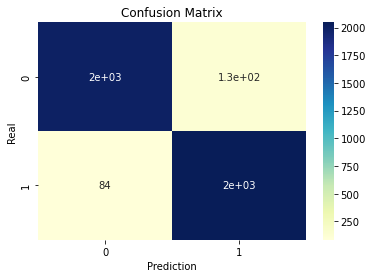

In [124]:
confusion_mat = confusion_matrix(y_true = rf_pred.select('Churn').toPandas(),
                                 y_pred = rf_pred.select('prediction').toPandas())

sb.heatmap(confusion_mat,
          annot=True,
          cmap="YlGnBu")

plt.title("Confusion Matrix")
plt.xlabel('Prediction')
plt.ylabel('Real')


The model selected is the Random Forest with next parameters:
- numTrees: 500
- maxDepth = 7
- impurity = 'gini'

In [125]:
sc.stop()
spark.stop()